In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [128]:
def get_index(r, nsup, lim=(-10, 10)):
    lo, hi = lim
    i = np.round((r - lo) / (hi - lo) * (nsup - 1))
    i = int(np.clip(i, 0, nsup - 1))
    return i


def update_dist(r, probs, lim=(-10, 10), gamma=0.8):
    nsup = probs.shape[0]
    bj = get_index(r, nsup, lim)
    m = probs.clone()
    j = 1
    for i in range(bj, 1, -1):
        m[i] += np.power(gamma, j) * m[i - 1]
        j += 1
    j = 1
    for i in range(bj, nsup - 1, 1):
        m[i] += np.power(gamma, j) * m[i + 1]
        j += 1
    m = m / m.sum()
    return m

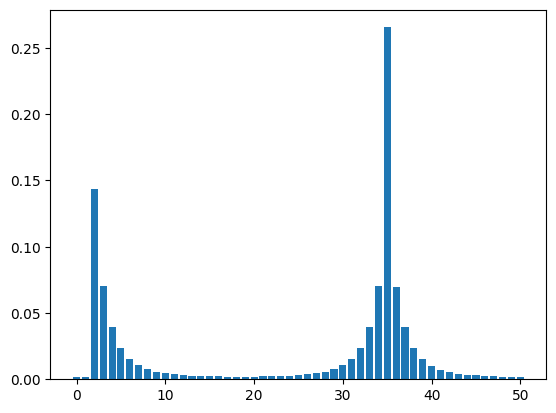

In [129]:
probs = torch.from_numpy(np.ones(51))
for _ in range(10):
    probs = update_dist(-9, probs)
for _ in range(10):
    probs = update_dist(4, probs)
plt.bar(range(51), probs);

In [130]:
def dist_dqn(x, theta, action_space=3):
    layer_dimensions = [(128, 100), (100, 25), *[(25, 51)] * action_space]
    layers = []
    e = 0
    for dim in layer_dimensions:
        s, e = e, e + np.prod(dim)
        layers.append(theta[s:e].reshape(dim))

    l1, l2, l3, l4, l5 = layers
    y = torch.selu(x @ l1)
    y = torch.selu(y @ l2)
    l3 = torch.stack([y @ l3, y @ l4, y @ l5], dim=1)
    l3 = torch.nn.functional.softmax(l3, dim=2)
    return l3.squeeze()

In [135]:
def get_target_dist(
    dist_batch, action_batch, reward_batch, support, lim=(-10, 10), gamma=0.8
):
    nsup = support.shape[0]
    target_dist_batch = dist_batch.clone()
    for i, (dist, action, reward) in enumerate(
        zip(dist_batch, action_batch, reward_batch)
    ):
        a = action.long().item()
        d = dist[a]
        if reward != -1:  # Terminal state, set the final reward.
            target_dist = torch.zeros(nsup)
            bj = get_index(reward, nsup, lim)
            target_dist[bj] = 1.0
        else:
            target_dist = update_dist(reward, d, lim=lim, gamma=gamma)
        target_dist_batch[i, a, :] = target_dist
    return target_dist_batch

In [136]:
def criterion(x, y):
    loss = torch.Tensor([0.0])
    loss.requires_grad = True
    for i in range(x.shape[0]):
        loss += -torch.log(x[i].flatten(start_dim=0)) @ y[i].flatten(start_dim=0)
    return loss

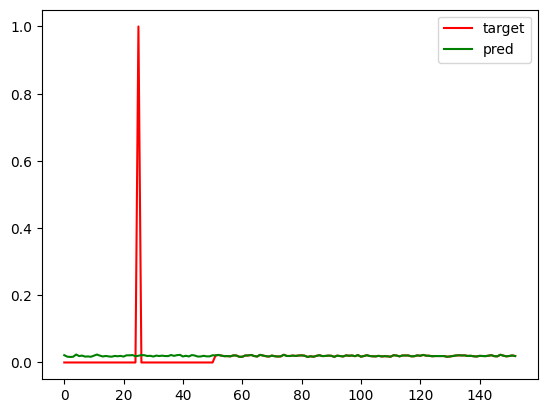

In [137]:
action_space = 3
total_params = 128 * 100 + 25 * 100 + action_space * 25 * 51
theta = torch.randn(total_params) / 10.0
theta.requires_grad = True
theta_2 = theta.detach().clone()
vmin, vmax = -10, 10
gamma = 0.9
lr = 1e-5
update_rate = 75
support = torch.linspace(-10, 10, 51)
state = torch.randn(2, 128) / 10.0
action_batch = torch.Tensor([0, 2])
reward_batch = torch.Tensor([0, 10])
losses = []
pred_batch = dist_dqn(state, theta, action_space=action_space)
target_dist = get_target_dist(
    pred_batch, action_batch, reward_batch, support, lim=(vmin, vmax), gamma=gamma
)
plt.plot(
    (target_dist.flatten(start_dim=1)[0].data.numpy()), color="red", label="target"
)
plt.plot((pred_batch.flatten(start_dim=1)[0].data.numpy()), color="green", label="pred")
plt.legend()